# HW 4 Cross-validation and Regularization

In this problem we will explore cross-validation, regularization, and PCA.

As before, you will write you homework into this notebook. You should probably create a new notebook to test out your solutions. After you are finished, make sure that your notebook can be run. Run your notebook, and submit the results. Do not delete the notebook cells that we supplied. Add as many cells as you need.
Fill in your name and netid in the following lines

In [1]:
netid = "xxx"
name = "xxx yyy"
print netid
print name

xxx
xxx yyy


<b>The following lines import the modules we will use.
Do not import any others</b>

In [2]:
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
%matplotlib inline

<b>Upon completing this problem set make sure that it can run. One way to check that is to click the menu button `Kernel`, and then select `Restart and Run All`. There should be no errors.</b> 

## Cross-validation
With cross-validation our goal is to somehow validate that we actually learned something rather than over-fit to the data. For instance, in the last problem set some of you (based on your seed), might have seen that your prediction was in fact worst than random guessing. We will look at that in this problem set and all see how regularization can help alleviate these problems.

### Hold out set validation
The most basic form of validation is to first create a training dataset and a testing dataset. The idea is then to perform all of the learning operations on the training dataset with a final testing at the end to check the results.
$K$-fold cross-validation provides a more accurate method.

### $K$-fold cross validation
Suppose that we have a set of data $\mathcal{X} = \{(a_i,b_i)\}_{i=1}^n$ where $a_i \in \mathbb{R}^d$ and $b_i \in \mathbb{R}$. We randomly partition the set $[n]$ into $K$ sub-groups: $\mathcal{I}_1,\mathcal{I}_2,...,\mathcal{I}_K\}$
where
$$
\mathcal{I}_j \bigcap \mathcal{I}_k = \emptyset \quad \textrm{when $j \neq k$}
$$
and
$$
\bigcup_{k=1}^K \mathcal{I}_k = [n]
$$
In words, the sets $\mathcal{I}_k$ form sets of example indices where none of the sets share an index and the union over all of the sets is the set of all integers between $1$ and $n$. Finally, we also assume that the sets are balanced. That is that, $|\mathcal{I}_k| = \frac{n}{k}$ where we are assuming $n$ is a multiple of $k$. Otherwise some of the sets will have $1$ extra element than the other sets.

It's fairly popular to pick $K$ between $2$ and $10$.

#### How do we use $K$-fold cross validation?

Suppose that we want to see how well our method can perform prediction. Namely, we are curious how well our method does prediction when we observe new data. We have some training data of features $A \in \mathbb{R}^{n \times d}$ along with some outcomes $b \in \mathbb{R}^n$. Our goal is to find an $x$ such that
$$
(a_i^T x - b_i)^2
$$
is small. We have learned that one way to do that is through linear regression so we solve
$$
\|A x - b\|_2^2.
$$
which ensures that the average squared error is small.
Unfortunately, this does not usually help us understand how well we will do given new data. For instance, if we are classifying if a digit is a one or a zero, we might want to know what to expect when we observe new data. This is where $K$-fold cross validation is useful. It works as the following psuedo code where we are assuming that the numpy array `I` is a matrix such that each row `I[k]` is a length $n$ numpy array where the entry is `True` if the index is in partition $k$ and it is `False` otherwise.
    

In [3]:
def crossvalidation(A,b,I):
    #A is the feature matrix
    #b is the outcomes vector
    #I is the numpy matrix where I[k] is a length n row of boolean values indexing the examples in partition k
    K=I.shape[0]
    erroratk=np.zeros(K)
    for j in range(K):
        xhat=SolveLinearRegression(A[np.logical_not(I[j])],b[np.logical_not(I[j])])
        erroratk[j]=np.sum((A[I[j],:].dot(xhat)-b[I[j]])**2)/np.sum(I[j])
    return erroratk

Note that, in the above we have not said how to actually solve linear regression. We can just assume that it is some generic function.

The key point to note is that we *learn* xhat on the points that are complement to partition $j$ and then we compute the average error on partition $j$. Hence, partition $j$ had nothing to do with the training so it acts as "new" data. We then loop this over all $j \in [K]$ to obtain an estimate of the different errors. Each loop is known as a fold and the error during a particular fold is the out-of-sample error at that fold. This error array can then be used to understand how much variation is in the error. If the error does not change very much then we have a stable estimator. If the error changes drastically across each of the folds, then our estimator is unstable. Storing different values of the error across different folds is the reason $K$-fold cross validation is often used over a training/testing set.

Let's load our modules and create some data to play around with.

In [4]:
np.random.seed(int((hashlib.md5('snn7')).hexdigest(),16) % 200000)
n=1000
d=700
u=np.random.normal(0,1,(1,d))
A=np.random.normal(0,1,(n,1)).dot(u) + np.random.normal(0,.1,(n,d))
xstar=np.random.normal(0,1,(d,1))
b=A.dot(xstar)+np.random.normal(0,1,(n,1))

Atest=np.random.normal(0,1,(n,1)).dot(u) + np.random.normal(0,.1,(n,d))
btest=Atest.dot(xstar)+np.random.normal(0,1,(n,1))

## Part A
Write a small function below called `SolveLinearRegression` to compute the Ordinary Least Squares (OLS) estimate using all of the data and check the error. That is solve
$$
\hat{x} = \arg \min_x \|A x - b\|_2^2
$$
and compute
$$
\|A \hat{x} - b\|_2^2
$$
Verify that it is small but the error on the test set is bigger.

In [5]:
def SolveLinearRegression(A,b):
    return np.linalg.solve(A.T.dot(A),A.T.dot(b))
    #return np.zeros((A.shape[1],1))


In [6]:
np.linalg.norm(A.dot(SolveLinearRegression(A,b)) - b)**2/A.shape[0], np.linalg.norm(Atest.dot(SolveLinearRegression(A,b)) - btest)**2/Atest.shape[0]

(0.31205045253010266, 3.3022324798525902)

The first number is the error on the training set. The second number is the error on the test set. The error on the training set is much smaller because we over fit to the data. Whereas on the test set we have never seen the data before so the error can be quite a bit larger.

## Part B
Now compute a $10$-fold cross validation. Provide the average error from the $10$ folds as well as the standard deviation (you can use `np.std`). The function `np.std` is an operation that is applied to numpy arrays. It is a measure of the amount of variation.

The error should be bigger. You can use the `crossvalidation` function above, but you will have to generate the numpy array `I` that provides the indices for each fold. It's called `Ifolds` below.

#### Solution


We create the folds by simply setting the test set in the cross validation folds to be disjoint sets of $100$ samples

In [7]:
Ifolds=(np.zeros((10,n))==1)
##put your Ifolds code generation here
for j in range(10):
    Ifolds[j][range(100*j,100*(j+1))]=True

In [8]:
assert np.sum(np.logical_or(Ifolds==True,Ifolds==False))==(10*n)
assert np.isclose(np.sum(Ifolds),(n))
assert np.all(np.isclose(np.sum(Ifolds,axis=1),np.ones((10,))*n/10.0))
assert np.all(np.isclose(np.sum(Ifolds,axis=0),np.ones((n,))))

In [9]:
## Put your cross validation code here
bb=crossvalidation(A,b,Ifolds)
np.mean(bb), np.std(bb)

(4.7149165470048526, 0.55797318793790229)

What we see above is that the average error and the standard deviation of the error

## Problem C
Let's recall ridge regression from class. We add a regularization term and solve the problem
$$
x_{\textrm{ridge},\lambda} = \arg \min_x \|A x - b\|_2^2 + \lambda \|x\|_2^2
$$
The term $\lambda$ is known as the regularization parameter. We will redefine `SolveLinearRegression` so that it takes an optional regularization parameter $\lambda$. You could solve it using gradient descent, but for a small problem it might be easier to use `np.linalg.solve`. Note that in your function you cannot call the parameter `lambda` because that is a special form in python.

#### Solution
Recall that for any optimization the optimality conditions state
$$
\nabla f(x) = 0
$$
is a sufficient and necessary condition for a point x to be the global minimum in an unconstrained convex optimization problem. Ridge regression is convex, therefore, the optimality conditions state
$$
2A^T(Ax-b) + 2 \lambda x = 0
$$
Solving for $x$
$$
x = (A^T A + \lambda I)^{-1} (A^T b)
$$

In [10]:
def SolveLinearRegression(A,b,la=0):
    return np.linalg.solve(A.T.dot(A)+la*np.identity(A.shape[1]),A.T.dot(b))
    ##return np.zeros((A.shape[1],1))

Check the optimality conditions that we wrote in class are valid for your method

In [11]:
la=1
A.shape, b.shape

((1000, 700), (1000, 1))

In [12]:
xridge=SolveLinearRegression(A,b,la=la)
assert np.isclose(np.linalg.norm(A.T.dot(A.dot(xridge) - b) + la * xridge),0)

In [13]:
np.linalg.norm(A.T.dot(A.dot(xridge) - b) + la * xridge)

4.2263292087240159e-10

In [14]:
np.linalg.norm(Atest.dot(xridge)-btest)**2/Atest.shape[0]

2.4488774477378179

## Problem D
Provide a plot where the $y$-axis is the $\|x_{\textrm{ridge},\lambda}\|_2^2$ and the $x$-axis is $\lambda$. What happens to the $\ell_2$ norm of the solution to ridge regression as $\lambda$ increases. You can use the the matrix $A$ and $b$ and do not need to cross validate. Why do you think this happens?

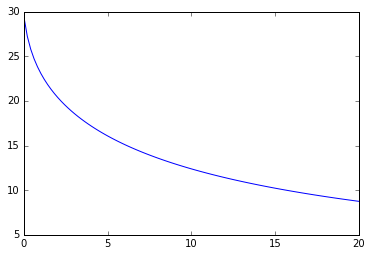

In [15]:
la=np.linspace(0,20,100)
#SolveLinearRegression(A,b,la=10)
#(lambda x: np.linalg.norm(SolveLinearRegression(A,b,la=x)))(10)
plt.plot(la,map(lambda x: np.linalg.norm(SolveLinearRegression(A,b,la=x)),la))
# plt.plot(la,np.apply_along_axis(lambda x: np.linalg.norm(SolveLinearRegression(A,b,la=x)),0,la))

The quantity $\|x_{\textrm{ridge},\lambda}\|_2^2$ decreases as $\lambda$ increases, because as $\lambda$ increases the optimization penalizes the size of the solution even more. As a result, the size of the solution (measured in $\ell_2$ norm) is expected to decrease.

## Problem E
A difficult challenge in many machine learning applications is to select the appropriate parameter $\lambda$. In general, this is called parameter tuning so $\lambda$ might also be called a tuning parameter. Take $20$ evenly spaced samples of $\lambda$ between $0$ and $3$. For each $\lambda$ perform cross validation. Plot the average error for each of the different values of $\lambda$. You are going to need to make a couple of small modifications to the `crossvalidation` function so that it accepts the extra tuning parameter.

Below we first plot the error on the test set versus lambda

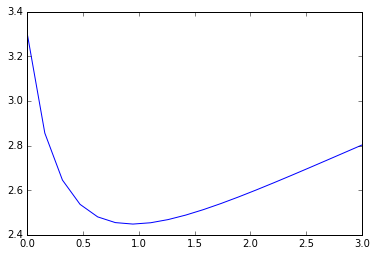

In [23]:
la=np.linspace(0,3,20)
GG=map(lambda x: np.linalg.norm(Atest.dot(SolveLinearRegression(A,b,la=x))-btest)**2/A.shape[0],la)
minla=la[np.argmin(GG)]
plt.plot(la,GG)

In [24]:
minla

0.94736842105263153

Now we look at is using cross validation

In [25]:
def crossvalidation(A,b,I,la=0):
    #A is the feature matrix
    #b is the outcomes vector
    #I is the numpy matrix where I[k] is a length n row of boolean values indexing the examples in partition k
    K=I.shape[0]
    erroratk=np.zeros(K)
    for j in range(K):
        xhat=SolveLinearRegression(A[np.logical_not(I[j])],b[np.logical_not(I[j])],la=la)
        erroratk[j]=np.sum((A[I[j],:].dot(xhat)-b[I[j]])**2)/np.sum(I[j])
    return erroratk

In [26]:
la=np.linspace(0,3,20)
GG=map(lambda x: np.mean(crossvalidation(A,b,Ifolds,x)),la)

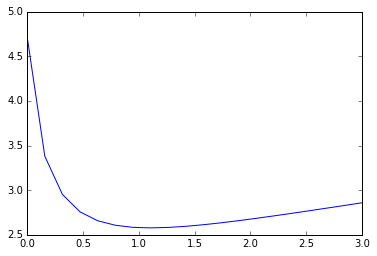

In [27]:
minla=la[np.argmin(GG)]
plt.plot(la,GG)

In [28]:
minla

1.1052631578947367

## Problem F
Pick the $\lambda$ with the smallest error from part E and call that $\lambda_{\textrm{best}}$. Now use the entire dataset to compute
$$
x_{\textrm{all}} = \arg \min_{x} \|A x - b\|_2^2 + \lambda_{\textrm{best}} \|x\|_2^2
$$

In [29]:
xbest=SolveLinearRegression(A,b,la=minla)

We will now generate a brand new set of examples.

In [34]:
n=1000
d=700
Anew=np.random.normal(0,1,(n,1)).dot(u) + np.random.normal(0,.1,(n,d))
bnew=Anew.dot(xstar)+np.random.normal(0,1,(n,1))

Using the above data compute the error $\ell_2$ error that $x_{\textrm{all}}$ achieves on the new dataset. Please note that you are not using $Anew$ to train. You are simply testing your data on $Anew$.

In [35]:
np.linalg.norm(bnew-Anew.dot(xbest))**2/Anew.shape[0]

2.2631532581089782

## Problem G

Finally, we know what the true `xstar` is. Provide a plot of $\|xstar - x_{\textrm{ridge},\lambda}\|_2^2$ as a function of $\lambda$. Use the new data generated above for this plot. How close is the $\lambda$ that achieves the smallest error here to the $\lambda$ found above?

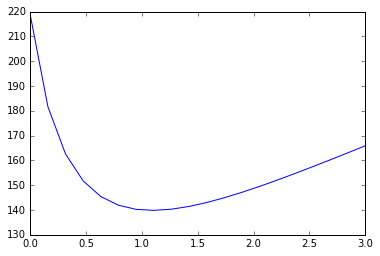

In [36]:
la=np.linspace(0,3,20)
GG=map(lambda x: np.linalg.norm(SolveLinearRegression(Anew,bnew,la=x)-xstar)**2,la)
minla=la[np.argmin(GG)]
plt.plot(la,GG)

In [37]:
minla

1.1052631578947367